## 간단한 컨볼루션넷

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (28, 28, 1))
x = layers.Conv2D(filters = 32, kernel_size = 3 , activation = 'relu')(inputs)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3 , activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3 , activation = 'relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation = 'softmax')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 17s 4ms/step - loss: 0.1630 - accuracy: 0.9492
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0464 - accuracy: 0.9864
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0333 - accuracy: 0.9898
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0240 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0190 - accuracy: 0.9941


In [5]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트 정확도 : {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0303 - accuracy: 0.9900
테스트 정확도 : 0.990


# 개 vs 고양이 이미지 분류하기

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyeontaelee","key":"3dd96eee16e99d6dba90709b3153bd52"}'}

In [14]:
!chmod 600 kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip --qq dogs-vs-cats.zip
!unzip -qq train.zip

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
# 이미지 -> 훈련, 검증, 테스트 디렉터리로 복사하기
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ('cat', 'dog'):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

make_subset("train", start_index = 0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)


In [17]:
# 소규모 모델 만들기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (180, 180, 3)) # 가로세로 180의 RGB 이미지를 인풋으로 기대
x = layers.Rescaling(1./255)(inputs) # 입력을 [0, 1]로 스케일을 조정함
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [18]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [19]:
# 데이터 전처리 : image_dataset_from_directory() 이용
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [21]:
# dataset 맛보기
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size = (1000, 16))

# 넘파이 배열, 튜플, 딕셔너리 -> Dataset 생성 가능
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

# 1개의 샘플 반환
for i, element in enumerate(dataset):
	print(element.shape)
	if i>=2:
		break

# 1개의 배치 반환
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
	print(element.shape)
	if i>=2:
		break

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)


In [23]:
# Dataset이 반환하는 데이터, 레이블 크기 확인하기
for data_batch, labels_batch in train_dataset:
  print("데이터 배치 크기 : ", data_batch.shape)
  print("레이블 배치 크기 : ", labels_batch.shape)
  break


데이터 배치 크기 :  (32, 180, 180, 3)
레이블 배치 크기 :  (32,)


In [24]:
# 모델 훈련
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = "convnet_from_scratch.keras",
    save_best_only = True,
    monitor = "val_loss"
)]
history = model.fit(train_dataset,
                    epochs= 30,
                    validation_data = validation_dataset,
                    callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 9s 80ms/step - loss: 0.6993 - accuracy: 0.4975 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 65ms/step - loss: 0.6942 - accuracy: 0.5220 - val_loss: 0.6918 - val_accuracy: 0.5290
Epoch 3/30
63/63 [==============================] - 6s 84ms/step - loss: 0.6938 - accuracy: 0.5450 - val_loss: 0.7262 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6749 - accuracy: 0.5915 - val_loss: 0.6403 - val_accuracy: 0.6220
Epoch 5/30
63/63 [==============================] - 8s 118ms/step - loss: 0.6154 - accuracy: 0.6685 - val_loss: 0.6408 - val_accuracy: 0.6470
Epoch 6/30
63/63 [==============================] - 7s 101ms/step - loss: 0.5749 - accuracy: 0.6930 - val_loss: 0.6311 - val_accuracy: 0.6770
Epoch 7/30
63/63 [==============================] - 6s 85ms/step - loss: 0.5361 - accuracy: 0.7240 - val_loss: 0.5984 - val_accuracy: 0.6770
Epoch 8/30


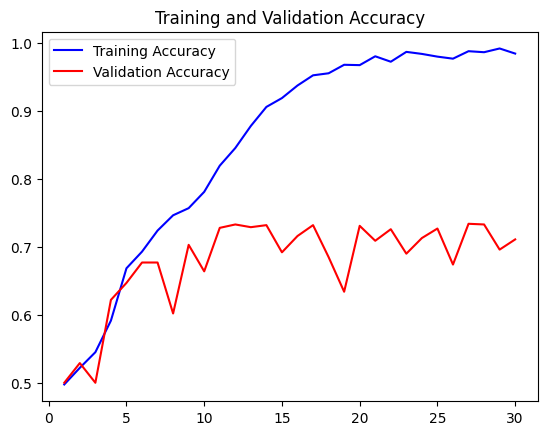

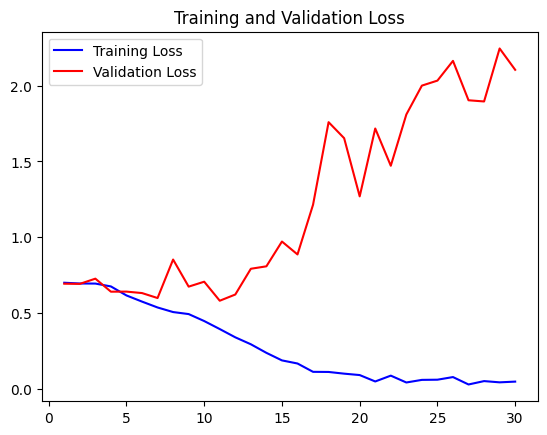

In [31]:
# 그래프 그리기
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy =history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label = "Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "b", label = "Training Loss")
plt.plot(epochs, val_loss, "r", label = "Validation Loss")
plt.title("Training and Validation Loss")

plt.legend()
plt.show()

In [26]:
# 테스트 세트에서 모델 평가하기
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도 : {test_acc:.3f}")

63/63 [==============================] - 4s 39ms/step - loss: 0.6431 - accuracy: 0.7235
테스트 정확도 : 0.724
